In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re

In [7]:
df_data = pd.read_excel(r"C:\Users\aleja\OneDrive\Documentos\2025-2\Inteligencia de Negocios\Proyectos\Proyecto 1\Datos_proyecto.xlsx")
df_data.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [8]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [12]:
df_data.columns

Index(['textos', 'labels'], dtype='object')

In [13]:
df_data.count()

textos    2424
labels    2424
dtype: int64

In [9]:
#Valores nulos por columna
print("Datos Nulos")
print(df_data.isnull().sum())

Datos Nulos
textos    0
labels    0
dtype: int64


In [16]:
#Eliminar filas sin texto o etiqueta
df = df_data.dropna(subset=["textos", "labels"])
df.count()

textos    2424
labels    2424
dtype: int64

In [20]:
duplicados = df.duplicated(subset = ["textos"])
print(f"Duplicados encontrados: {duplicados.sum()}")

Duplicados encontrados: 0


In [24]:
# 6. Eliminar duplicados exactos (mismo texto y misma etiqueta)
df = df.drop_duplicates(subset=["textos", "labels"])
df.count()

textos    2424
labels    2424
dtype: int64

In [27]:
df["world_count"] = df["textos"].apply(lambda x: len(str(x).split()))

In [28]:
print("Textos Cortos")
print(df[df["world_count"] < 5])

Textos Cortos
Empty DataFrame
Columns: [textos, labels, world_count]
Index: []


In [52]:
print("Textos Largos")
print(df[df["world_count"] > 500])

Textos Largos
Empty DataFrame
Columns: [textos, labels, world_count]
Index: []


In [31]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
print(df["labels"].value_counts())

Distribución de clases:
labels
4    1025
3     894
1     505
Name: count, dtype: int64


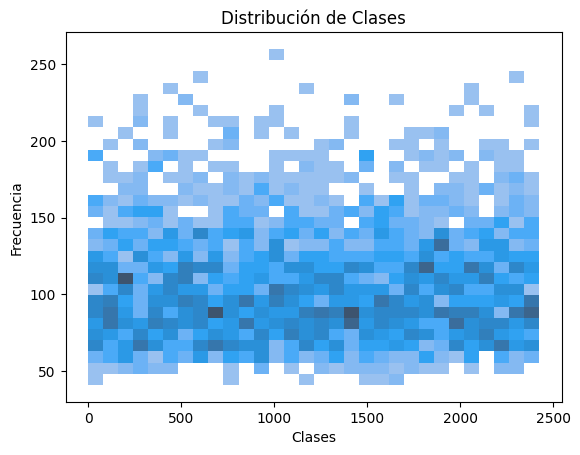

In [54]:
sns.histplot(x= df["world_count"].index, y=df["world_count"].values, bins=30)
plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()


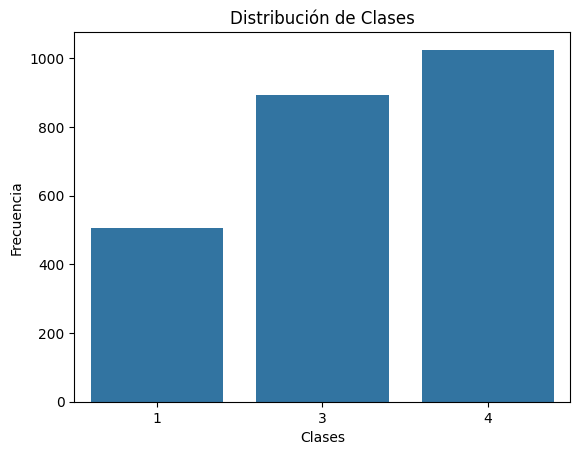

In [35]:
sns.barplot(x=df["labels"].value_counts().index, y=df["labels"].value_counts().values)
plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

# Experimentos varios que no tienen mucho que hacer

In [55]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('spanish')

def normalize_text(text):
    #Elimina caracteres especiales y espacios en blanco
    doc = re.sub(r'[^a-zA-Z\s]', "", text, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    #Tokenizar documento
    tokens = wpt.tokenize(doc)
    #Filtrar palabras
    filtered_tokens = [token for token in tokens if token not in stop_words]
    #Recrear documento de texto
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = df["textos"].apply(normalize_text)
df_normalizado = df.copy()
df_normalizado["textos"] = normalize_corpus
df_normalizado.head()

,textos,labels,world_count
0,aprendizaje educacin consideran sinnimos escol...,4,48
1,nios ms pequeos bebs nios pequeos capacitacin ...,4,72
2,adems formacin especialistas medicina general ...,3,93
3,pases ocde tiende pasar cursos obligatorios op...,4,109
4,grupo centr personas padecen trastornos mental...,3,94
